In [20]:
from const import *
from function import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
import itertools

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from catboost import Pool

warnings.simplefilter('ignore')

In [21]:
data_path = '../1.data/'
train_file_name = 'train.csv'
test_file_name  = 'test.csv'

In [22]:
def creansing_dataset(df):
    # year
    is_error_year = df['year'] > 2023
    df.loc[is_error_year, 'year'] = df[is_error_year]['year'] - 1000
    # size
    df['size'] = df['size'].replace(size_replace)
    # manufacturer
    df['manufacturer'] = df['manufacturer'].replace(manufactuer_replace)
    # odometer
    is_odo_error = df['odometer']<-1
    is_odo_unknown = df['odometer']==-1
    df.loc[is_odo_error, 'odometer'] = df[is_odo_error]['odometer'] * (-1)
    df.loc[is_odo_unknown, 'odometer'] = np.nan

    return df

In [23]:
train_df = pd.read_csv(f'{data_path}{train_file_name}')
test_df = pd.read_csv(f'{data_path}{test_file_name}')
master_df = creansing_dataset(pd.concat([train_df, test_df]))

In [24]:
non_cols = ['id', 'price']
num_cols = ['year', 'odometer']
cat_cols = [col for col in train_df.columns if col not in non_cols + num_cols]

In [25]:
# df = master_df.copy()

# f_odometer = df['odometer'] < 400000
# df.loc[f_odometer, 'bins'] = pd.cut(df[f_odometer]['odometer'], bins=30)
# for col in cat_cols + ['price']:
#     df_tile = df.groupby(['bins', col]).agg(
#         odo_25_pertile = ('price', lambda sr:sr.quantile(0.25)), 
#         odo_50_pertile = ('price', lambda sr:sr.quantile(0.5)), 
#         odo_75_pertile = ('price', lambda sr:sr.quantile(0.75)), 
#         odo_std = ('price', 'std')
#     ).add_prefix(f'{col}_').reset_index()

#     df = df.merge(df_tile, on=['bins', col], how='left')
#     break

# df.head()

In [26]:
def add_odometer_price_tile(df):
    f_odometer = df['odometer'] < 400000
    df.loc[f_odometer, 'bins'] = pd.cut(df[f_odometer]['odometer'], bins=30)
    for col in cat_cols + ['year']:
        df_tile = df.groupby(['bins', col]).agg(
            odo_25_pertile = ('price', lambda sr:sr.quantile(0.25)), 
            odo_50_pertile = ('price', lambda sr:sr.quantile(0.5)), 
            odo_75_pertile = ('price', lambda sr:sr.quantile(0.75)), 
            odo_std = ('price', 'std')
        ).add_prefix(f'{col}_').reset_index()

        df = df.merge(df_tile, on=['bins', col], how='left')
        
    return df.drop('bins', axis=1)

In [27]:
def create_num_features(df):
    df['elapsed_year'] = 2023 - df['year']
    df = add_odometer_price_tile(df)

    del df['year']

    return df


def create_cat_features(df):
    for col in cat_cols:
        df[col] = df[col].factorize()[0]
        df[col] = df[col].astype('category')
    return df


def create_features_main(df):
    df = create_num_features(df)
    df = create_cat_features(df)

    return df

In [28]:
def built_catboost_model(cat_features, Xt, yt, Xe, ye):
    model = \
        CatBoostRegressor(
            learning_rate = 0.1,
            iterations=500,
            loss_function = 'MAPE',
            early_stopping_rounds = 10,
            random_seed = 42
        )

    model.fit(
        X = Xt, y = yt,
        eval_set = (Xe, ye),
        cat_features = cat_features, 
        use_best_model = True, 
        verbose = 100
    )

    return model


def mape(true, pred):
    return np.mean(np.abs((pred - true) / true)) 

In [29]:
def plot_result(preds):
    pred_df_l = []
    for i in range(cv):
        pred_df_l.append(
            pd.DataFrame(np.array(preds[i]).T, columns=['id', 'actual', 'pred'])
        )

    pred_df = pd.concat(pred_df_l)

    plt.figure(figsize=(8,5), facecolor="azure", edgecolor="coral", linewidth=2)
    bins = np.linspace(0, pred_df['actual'].max(), 200)
    plt.hist(pred_df['actual'], bins, alpha = 0.5, label='actual')
    plt.hist(pred_df['pred'], bins, alpha = 0.5, label='b')


    fig = plt.figure(figsize=(5,5), facecolor="azure", edgecolor="coral", linewidth=2)
    ax1 = fig.add_subplot()
    ax1.set_ylim([0, pred_df['actual'].max()])
    ax1.set_xlim([0, pred_df['actual'].max()])
    ax1.scatter(pred_df['actual'], pred_df['pred'])

    fig = plt.figure(figsize=(5,5), facecolor="azure", edgecolor="coral", linewidth=2)
    ax1 = fig.add_subplot()
    ax1.set_ylim([0, np.exp(pred_df['actual']).max()])
    ax1.set_xlim([0, np.exp(pred_df['pred']).max()])
    ax1.scatter(np.exp(pred_df['actual']), np.exp(pred_df['pred']))


def plot_importance(importnace_l, show_n=50):
    imp_df = pd.DataFrame(index=input_cols)
    for i in range(len(importnace_l)):
        imp_df[f'cv{i+1}'] = importnace_l[i]

    imp_df['mean'] = imp_df.mean(axis=1)
    imp_df = imp_df.sort_values('mean').tail(show_n)

    plt.figure(figsize=(8,12), facecolor="azure", edgecolor="coral", linewidth=2)
    plt.boxplot(
        [imp_df.T[col].values for col in imp_df.index],
        labels = imp_df.index, 
        vert=False
    )

In [30]:
master_df = create_features_main(master_df)
train_df = master_df[~master_df['price'].isnull()].reset_index(drop=True).copy()
train_df['price'] = np.log(train_df['price'])
test_df  = master_df[master_df['price'].isnull()].copy()

In [31]:
cv = 4
kf = KFold(n_splits=cv)

models = []
preds  = []
scores = []
importnace_l = []

input_cols = train_df.drop(columns=['price', 'id']).columns

In [32]:
for train_index, valid_index in kf.split(train_df):
    x_train = train_df.iloc[train_index].drop(columns=['price', 'id'])
    y_train = train_df.iloc[train_index]['price']
    x_valid = train_df.iloc[valid_index].drop(columns=['price', 'id'])
    y_valid = train_df.iloc[valid_index]['price']

    model = built_catboost_model(
        cat_cols, x_train, y_train, x_valid, y_valid
    )

    valid_pred = model.predict(x_valid)

    scores.append(mape(y_valid, valid_pred).round(5))
    preds.append([valid_index, y_valid.values, valid_pred])
    models.append(model)
    importnace_l.append(model.get_feature_importance())

    del x_train, y_train, x_valid, y_valid, model

0:	learn: 0.0691166	test: 0.0693293	best: 0.0693293 (0)	total: 55.2ms	remaining: 27.5s
100:	learn: 0.0436475	test: 0.0453107	best: 0.0453107 (100)	total: 7.34s	remaining: 29s
200:	learn: 0.0417888	test: 0.0443995	best: 0.0443995 (200)	total: 14.9s	remaining: 22.2s
300:	learn: 0.0407308	test: 0.0442025	best: 0.0442025 (300)	total: 23.4s	remaining: 15.5s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.04415604041
bestIteration = 362

Shrink model to first 363 iterations.
0:	learn: 0.0692047	test: 0.0690981	best: 0.0690981 (0)	total: 121ms	remaining: 1m
100:	learn: 0.0437734	test: 0.0447244	best: 0.0447244 (100)	total: 10.2s	remaining: 40.2s
200:	learn: 0.0420154	test: 0.0438033	best: 0.0438033 (200)	total: 19.5s	remaining: 29s
300:	learn: 0.0410062	test: 0.0435853	best: 0.0435853 (300)	total: 28.4s	remaining: 18.8s
400:	learn: 0.0403429	test: 0.0434740	best: 0.0434723 (396)	total: 35.9s	remaining: 8.86s
Stopped by overfitting detector  (10 iterations wait)

bestTest =

In [33]:
print(f'scores = {scores}')
print(f'mean_score = {np.mean(scores).round(5)}')

scores = [0.04416, 0.04341, 0.04389, 0.04331]
mean_score = 0.04369


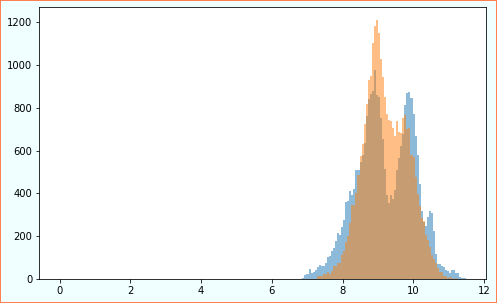

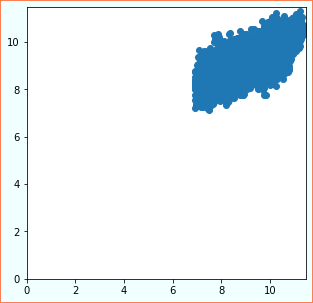

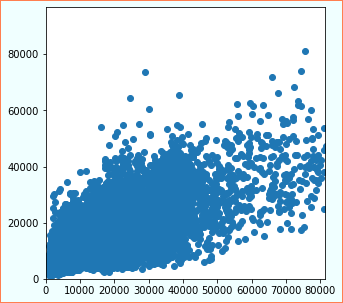

In [34]:
plot_result(preds)

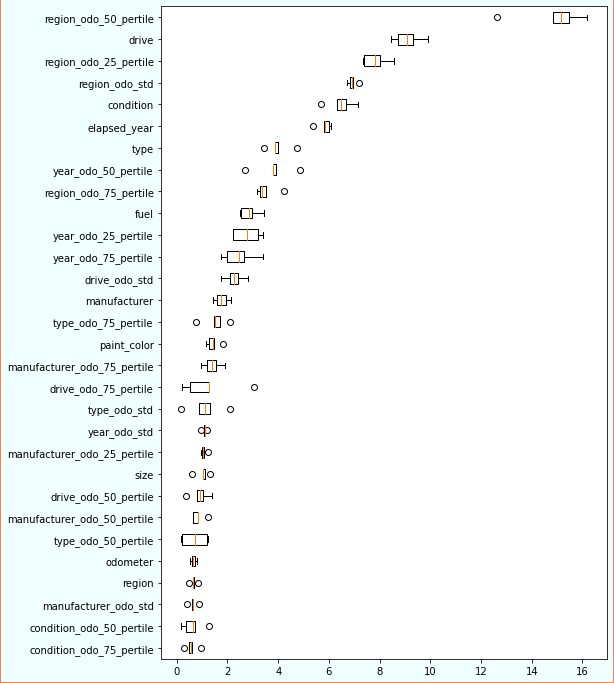

In [35]:
plot_importance(importnace_l, 30)

In [36]:
from datetime import datetime
output_name = str(datetime.now().strftime('%Y%m%d %H:%M:%S')).replace('-','').replace(':','')

submit_df = pd.read_csv(f'{data_path}submit_sample.csv', header=None)
for fold in range(cv):
    submit_df[f'fold{fold}'] = np.exp(models[fold].predict(test_df[input_cols]))


submit_df['mean'] = submit_df[[f'fold{i}' for i in range(cv)]].mean(axis=1)
# submit_df[[0, 'mean']].to_csv(f'../3.hist/{output_name}.csv', index=False, header=None)